In [49]:
import requests
import time
import pandas as pd
import json
import csv
import numpy as np
import re
from datetime import datetime
import matplotlib.pyplot as plt


**Part I. Data Collection**



Collection of New York Times articles with the word "anxiety" or "depression" on the headline (NATASHA)

In [25]:
#Basic details needed to interact with The New York Times API
api_key = "" #deleted after interaction with the API
base_url = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

def collect_articles_NYT(word, output_file_name): 
    '''
    Interact with The New York Times API to collect articles' data. Restrict
    the search to those articles containing the given word in the headline.
    Lastly, generate a json file to store the data so it can be easily 
    retrieved later without needing to make requests every time. 

    Inputs: 
        word (str): word of interest for the query
        output_file_name (str): desired name for the json file to be created

    Outputs:
        json file
    '''

    articles = {}

    for year in range(2004,2025):

        year_data = []

        #Since the API only retrieves 10 results per query, we have to loop 
        #through different pages. The range 0-100 is set up since it is the
        #maximum number of pages that can be requested.
        for page in range(0,100):

            begindate = "{}0101".format(year)
            enddate = "{}1231".format(year)
            nyt_params = {"q": word, "fq": f'headline:{word}',
                        "begin_date": begindate, "end_date": enddate, 
                        "page": page, "api-key": api_key}
            
            response = requests.get(base_url, params= nyt_params)
            page_data = response.json()
            time.sleep(14)

            #After collecting all available data, subsequent pages retrieve
            #empty results. For that reason, we can break the loop when pages 
            #are no longer useful. It also avoids making unnecessary and 
            #time-consuming requests
        
            if len(page_data["response"]["docs"]) == 0:
                break

            year_data += page_data["response"]["docs"]

        articles[year] = year_data

    #Export the dictionary to a JSON file to save it locally to avoid needing
    #to make requests every time we work on the project. 
    with open(output_file_name, 'w') as json_file:
        json.dump(articles, json_file, indent=4)


#Call function to retrieve NYT articles related to anxiety and depression

#collect_articles_NYT("anxiety", "anxiety_articles_NYT.json")
#collect_articles_NYT("depression", "depression_articles_NYT.json")

Collection of The Guardian's articles with the word "anxiety" or "depression" on the headline (YUE)

In [26]:
#according to chatgpt, i added pages and loop through each pages. 
def search_guardian_api(api_key, query, from_date, to_date):
    base_url = "https://content.guardianapis.com/search"
    
    params = {
        'api-key': api_key,
        'q': query,
        'order-by': 'newest',
        'from-date': from_date,
        'to-date': to_date,
        'show-fields': 'headline,bodyText,webPublicationDate',  
        'section': 'society' or 'wellness' 
    }
    
    all_articles = []
    page = 1
    total_articles = float('inf')  # Initialize to infinity
    
    while len(all_articles) < total_articles:
        params['page'] = page
        response = requests.get(base_url, params=params)

        if response.status_code == 200:
            data = response.json()
            articles = data.get('response', {}).get('results', [])
            total_articles = data.get('response', {}).get('total', 0)
            
            for article in articles:
                headline = article.get('fields', {}).get('headline', '')
                publication_date = article.get('webPublicationDate', '')
                body_text = article.get('fields', {}).get('bodyText', '')
                all_articles.append({'Headline': headline, 
                 'Publication Date': publication_date, 'Body Text': body_text})
            
            page += 1
        else:
            print(f"Error: {response.status_code}, {response.text}")
            break
    
    return all_articles

api_key = ' ' #deleted after collection
from_date = '2004-01-01'
to_date = '2024-02-07'

#Call to retrieve anxiety articles
query = 'anxiety'
#anxiety_articles = search_guardian_api(api_key, query, from_date, to_date)
#df = pd.DataFrame(anxiety_articles)
#df.to_csv('anxiety_articles.csv', index=False)

#Call to retrieve depression articles
query = 'depression'
#depression_articles = search_guardian_api(api_key, query, from_date, to_date)
#df = pd.DataFrame(depression_articles)
#df.to_csv('depression_articles.csv', index=False)

Collecting total number of articles published (yearly) on The New York Times for the past 20 years (NATASHA)

In [27]:
total_n_nyt = {}

for year in range(2004,2025):
    
    begindate = "{}0101".format(year)
    enddate = "{}1231".format(year)
    nyt_params = { "begin_date": begindate, "end_date": enddate, 
                   "api-key": api_key}
            
    #response = requests.get(base_url, params= nyt_params)
    #data = response.json()

    #Extract number of total articles from the metadata. ("Hits" refers to
    #total number of results
    #total_n_articles = data["response"]["meta"]["hits"]
    #time.sleep(12)

    #total_n_nyt[year] = total_n_articles

#with open("yearly_n_all_nyt", 'w') as json_file:
    #json.dump(total_n_nyt, json_file, indent=4)

with open("./yearly_n_all_nyt", "r") as json_file:
        total_n_nyt = json.load(json_file)

#I asked ChatGPT: "how can I convert a dictionary of keys with just one value 
#"into a pandas dataframe?" and it gave me the following code: 

df_all_yearly_nyt= pd.DataFrame.from_dict(total_n_nyt, orient='index', 
                            columns=['Total number of articles'])



Collecting total number of articles published (monthly) on The New York Times on the timeframe between July 1, 2019 and January 31, 2024 (NATASHA)

In [28]:
#Create list of begin days and end days for the requests

formatted_dates = []

for year in range(2019, 2025):
    for month in range(1,13):
        f_month = '{:02d}'.format(month)
        beginday = "{}{}01".format(year, f_month)
        if month in [4, 6, 9, 11]:
            endday = "{}{}30".format(year, f_month)
        elif month == 2 and year == 2020:
            endday = "{}{}29".format(year, f_month)
        elif month == 2:
            endday = "{}{}28".format(year, f_month)
        else:
            endday = "{}{}31".format(year, f_month)

        formatted_dates.append((beginday, endday))  

#Removing months before July 2019 and after January 2024
useful_dates = formatted_dates[6:61]

#Create dictionary to store monthly counts

monthly_total_nyt = {}

for month in useful_dates:
    beginday, endday = month

    nyt_params = { "begin_date": beginday, "end_date": endday, 
                   "api-key": api_key}
    
    #response = requests.get(base_url, params= nyt_params)
    #data = response.json()
    #total_n_articles_month = data["response"]["meta"]["hits"]
    #monthly_total_nyt[month] = total_n_articles_month
    #time.sleep(12)

#Store the info in a csv file
csv_file = 'monthly_n_nyt.csv'

#with open(csv_file, 'w', newline='') as file:
    #writer = csv.writer(file)
    
    #for key, value in monthly_total_nyt.items():
        #writer.writerow([key, value])

#Create dataframe 
df_all_monthly_nyt = pd.read_csv('monthly_n_all_nyt.csv', names= ["Month", "Count of all articles"])
 
        

Collecting total number of articles published (yearly) on The Guardian for the past 20 years (YUE)

In [29]:
def count_articles_by_year(api_key, from_date, to_date):
    base_url = "https://content.guardianapis.com/search"
    
    total_articles_by_year = {}
    
    # Extract start and end years
    start_year = int(from_date[:4])
    end_year = int(to_date[:4]) + 1  # Add 1 to include the end year
    
    for year in range(start_year, end_year):
        # Set the from-date and to-date parameters for the current year
        year_from_date = f"{year}-01-01"
        year_to_date = f"{year}-12-31"
        
        params = {
            'api-key': api_key,
            'from-date': year_from_date,
            'to-date': year_to_date,
            'page-size': 1,  # Set page size to 1 as we're only interested in checking the existence of articles
        }
        
        response = requests.get(base_url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            total = data.get('response', {}).get('total', 0)
            total_articles_by_year[str(year)] = total
        else:
            print(f"Error: {response.status_code}, {response.text}")
            total_articles_by_year[str(year)] = 0  # Set count to 0 for the current year in case of error
    
    return total_articles_by_year

# Example usage:
api_key = '93eb884c-6abd-444e-aba9-95bba2d84dad'
from_date = '2004-01-01'
to_date = '2024-02-07'

#total_articles_by_year = count_articles_by_year(api_key, from_date, to_date)

#We copied the dictionary to a csv file "yearly_n_all_guardian.csv" to store it 


**Part II. Data Cleaning**

Create initial dataframes for NYT articles (NATASHA)

In [30]:
def create_df_NYT_articles(jsonfilepath): 
    '''
    Given a JSON file containing NYT's articles data, create a data frame that 
    contains useful information 

    Inputs: 
        jsonfilepath (str): name of the file preceeded by its path

    Returns:
        DataFrame containing information of the articles (year published,
        specific date, headlines and abstracts)
    '''

    #Open json file as a python dictinary
    with open(jsonfilepath, "r") as json_file:
        dictdata = json.load(json_file)

    #Loop through each item in the dictionary to get the most relevant information
    #of the articles and store it in a dataframe

    cols = {"year" : [], "specific_date": [], "section": [], 'subsection': [],
                                                 'headlines':[], 'abstracts':[]}

    for year_x in range(2004,2025):
        year_data = dictdata[str(year_x)]
        for index, article in enumerate(year_data):

            
            cols["year"].append(year_x)
            cols['specific_date'].append(article['pub_date'])
            cols['headlines'].append(article["headline"]["main"])
            cols['abstracts'].append(article['abstract'])

            try:
                cols['section'].append(article["section_name"])
            except:
                cols['section'].append(None)

            try:
                cols['subsection'].append(article["subsection_name"])
            except:
                cols['subsection'].append(None)

    df = pd.DataFrame(cols)
    return df

#Call function to create data frame for NYT's anxiety articles
anx_nyt_df = create_df_NYT_articles("./anxiety_articles_NYT.json")

#Create dataframe for NYT's depression articles
dep_nyt_df = create_df_NYT_articles("./depression_articles_NYT.json")


NYT data cleaning (JAYDA)

In [31]:
# create function to clean nyt data frame
def clean_nyt_df(df, anxiety_depression_ID):
    # filter out Great Depression articles
    new_df = df.drop(df[df['headlines'].str.contains("Great Depression")].index)

    # add NYT id
    new_df["Sources"] = 0

    # add anxiety_depression_ID
    new_df["Anxiety or Depression"] = anxiety_depression_ID

    # standardize date format
    new_df["specific_date"] = new_df["specific_date"].astype(str)
    new_df["date"] = new_df["specific_date"].str.extract(r"(.{10})T", expand=True)

    # make time frame variable
    new_df["date"] = pd.to_datetime(new_df["date"])

    pre = pd.to_datetime("2020-03-11")
    post = pd.to_datetime("2024-05-11")

    time_frames = [
        (new_df["date"] < pre),
        (new_df["date"] < post)]

    values = [0, 2]

    new_df['Time frame'] = np.select(time_frames, values, default=1)

    # make month and day variables
    new_df["Month"] = new_df["specific_date"].str.extract(r"-([0-9]{2})", expand=True)
    new_df["Date"] = new_df["specific_date"].str.extract(r"([0-9]{2})T", expand=True)
    new_df["Year"] = new_df["year"]

    # clean headlines and abstracts 
    new_df["Title"]  = [re.sub(r'[^\w\s]', '', i).lower() for i in new_df["headlines"]]
    new_df["Abstract"]  = [re.sub(r'[^\w\s]', '', i).lower() for i in new_df["abstracts"]]

    return new_df

In [32]:
clean_nyt_anx = clean_nyt_df(anx_nyt_df, 0)
clean_nyt_anx.head()

,year,specific_date,section,subsection,headlines,abstracts,Sources,Anxiety or Depression,date,Time frame,Month,Date,Year,Title,Abstract
0,2004,2004-03-14T05:00:00+0000,Arts,None,High Anxiety,James Glanz article on safety precautions bein...,0,0,2004-03-14,0,03,14,2004,high anxiety,james glanz article on safety precautions bein...
1,2004,2004-08-22T05:00:00+0000,Books,None,'Status Anxiety',"""Money, fame and influence may be valued more ...",0,0,2004-08-22,0,08,22,2004,status anxiety,money fame and influence may be valued more as...
2,2004,2004-12-06T05:00:00+0000,Archives,None,Anxiety for an American Family,"Interview with Carolyn Richard, Adairsville, G...",0,0,2004-12-06,0,12,06,2004,anxiety for an american family,interview with carolyn richard adairsville ga ...
3,2004,2004-09-05T05:00:00+0000,Books,None,Short Stories: Anxiety Attacks,Jeff Turrentine reviews books The Secret Goldf...,0,0,2004-09-05,0,09,05,2004,short stories anxiety attacks,jeff turrentine reviews books the secret goldf...
4,2004,2004-02-29T05:00:00+0000,Sports,None,"High Velocity, Some Anxiety",New York Yankees pitcher Kevin Brown prepares ...,0,0,2004-02-29,0,02,29,2004,high velocity some anxiety,new york yankees pitcher kevin brown prepares ...


In [33]:
clean_nyt_dep = clean_nyt_df(dep_nyt_df, 1)
clean_nyt_dep.head()

,year,specific_date,section,subsection,headlines,abstracts,Sources,Anxiety or Depression,date,Time frame,Month,Date,Year,Title,Abstract
0,2004,2004-12-10T05:00:00+0000,U.S.,None,Study Pursues a Genetic Link to Depression,Scientists at Duke University find genetic var...,0,1,2004-12-10,0,12,10,2004,study pursues a genetic link to depression,scientists at duke university find genetic var...
1,2004,2004-12-17T05:00:00+0000,U.S.,None,Study Suggests Way to Predict Whom Antidepress...,Harvard and UCLA researchers find that common ...,0,1,2004-12-17,0,12,17,2004,study suggests way to predict whom antidepress...,harvard and ucla researchers find that common ...
2,2004,2004-12-07T05:00:00+0000,Health,None,Tracking Stress and Depression Back to the Womb,Studies indicate that stress and depression in...,0,1,2004-12-07,0,12,07,2004,tracking stress and depression back to the womb,studies indicate that stress and depression in...
3,2004,2004-09-12T05:00:00+0000,Business Day,None,"Depression, a Frequent Visitor to Wall St.",Rate of chronic depression seems to be high am...,0,1,2004-09-12,0,09,12,2004,depression a frequent visitor to wall st,rate of chronic depression seems to be high am...
4,2004,2004-08-25T05:00:00+0000,U.S.,None,New Therapy On Depression Finds Phone Is Effec...,Study reported in Journal of the American Medi...,0,1,2004-08-25,0,08,25,2004,new therapy on depression finds phone is effec...,study reported in journal of the american medi...


In [34]:
# combine data frames and filter desired columns
filter = ["Sources", "Month", "Date", "Year", "Anxiety or Depression", "Title", "Abstract", "Time frame"]
clean_nyt = pd.concat([clean_nyt_anx, clean_nyt_dep], axis=0)[filter]

clean_nyt.to_csv("clean_nyt", sep=',', index=False)

The Guardian data cleaning (KEXIN)

In [35]:
anxiety_df = pd.read_csv('anxiety_articles_guardian.csv', low_memory=False)
depression_df = pd.read_csv('depression_articles_guardian.csv', low_memory=False)

anxiety_df['Anxiety or Depression'] = 0  # 0 for anxiety articles
depression_df['Anxiety or Depression'] = 1  # 1 for depression articles

combined_df = pd.concat([anxiety_df, depression_df], axis = 0, ignore_index=True)

combined_df.rename(columns={'Headline': 'Title'}, inplace=True)

combined_df['Sources'] = '1' # 1 for The Guardian

# Convert 'Publication Date' to datetime and remove rows with invalid or missing dates
combined_df['Publication Date'] = pd.to_datetime(combined_df['Publication Date'], errors='coerce')
combined_df = combined_df.dropna(subset=['Publication Date'])

# Remove timezone information from 'Publication Date'
combined_df['Publication Date'] = combined_df['Publication Date'].dt.tz_localize(None)

# Extract 'Month', 'Date', and 'Year'
combined_df['Month'] = combined_df['Publication Date'].dt.month
combined_df['Date'] = combined_df['Publication Date'].dt.day
combined_df['Year'] = combined_df['Publication Date'].dt.year

# Define the criteria for 'Time frame'
pre_date = datetime.strptime('2020-03-11', '%Y-%m-%d')
post_date = datetime.strptime('2023-05-11', '%Y-%m-%d')

# Function to determine the 'Time frame'
def determine_time_frame(row):
    if row['Publication Date'] < pre_date:
        return 0  # Pre
    elif row['Publication Date'] <= post_date:
        return 1  # During
    else:
        return 2  # Post

# Apply the function to set the 'Time frame'
combined_df['Time frame'] = combined_df.apply(determine_time_frame, axis=1)

# Remove the original 'Publication Date' column
combined_df.drop(columns=['Publication Date'], inplace=True)

def clean_text(text):
    if isinstance(text, str):
        text = text.lower() # Convert to lowercase
        text = re.sub(r'[^\w\s]', '', text) # Remove punctuation
        text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    else:
        text = "" # Replace missing values with empty strings
    return text

combined_df['Title'] = combined_df['Title'].apply(clean_text)
combined_df['Body Text'] = combined_df['Body Text'].apply(clean_text)

combined_df.dropna(subset=['Title', 'Body Text'], inplace=True)

combined_df = combined_df[['Sources', 'Month', 'Date', 'Year',
                           'Anxiety or Depression', 'Title',
                           'Body Text', 'Time frame']]

#combined_df.to_csv('combined_articles_guardian.csv', index=False)

Remove duplicates from the guardian


In [42]:
guardian = pd.read_csv('combined_articles_guardian.csv')
print(len(guardian))
print(guardian['Anxiety or Depression'].value_counts())

#create mask to find duplicates in df
duplicates = guardian.duplicated(subset='Title')

print(len(guardian[duplicates].value_counts()))

# create mask to find if an article is a duplicate (to find original articles)
mask = guardian['Title'].isin(guardian[duplicates]['Title'].tolist())

# set duplicate articles to 2 in 'Anxiety or Depression' column
guardian.loc[mask, 'Anxiety or Depression'] = 2

new = guardian.drop_duplicates('Title')

print(new['Anxiety or Depression'].value_counts())
print(len(new))

6041
Anxiety or Depression
1    3092
0    2949
Name: count, dtype: int64
1295
Anxiety or Depression
1    1804
0    1688
2    1253
Name: count, dtype: int64
4745


**Part III. Data Analysis**

### Calculating proportion 

#### total number of articles per year



In [46]:
def count_articles_by_year(api_key, from_date, to_date):
    base_url = "https://content.guardianapis.com/search"
    
    total_articles_by_year = {}
    
    start_year = int(from_date[:4])
    end_year = int(to_date[:4]) + 1  
    
    for year in range(start_year, end_year):
        year_from_date = f"{year}-01-01"
        year_to_date = f"{year}-12-31"
        
        params = {
            'api-key': api_key,
            'from-date': year_from_date,
            'to-date': year_to_date,
            'page-size': 1,  
        }
        
        response = requests.get(base_url, params=params)
        
        if response.status_code == 200:
            data = response.json()
            total = data.get('response', {}).get('total', 0)
            total_articles_by_year[str(year)] = total
        else:
            print(f"Error: {response.status_code}, {response.text}")
            total_articles_by_year[str(year)] = 0  
    
    return total_articles_by_year

api_key = 'e28be7aa-fce5-460b-afe8-dc01a3a5f68d'
from_date = '2004-01-01'
to_date = '2024-02-07'

total_articles_by_year = count_articles_by_year(api_key, from_date, to_date)
df = pd.DataFrame(list(total_articles_by_year.items()), columns=['Year', 'Total Articles'])
df.to_csv('total_articles_by_year.csv', index=False)

### anxiety article per year

In [44]:
df = pd.read_csv('combined_articles_guardian.csv')

anxiety_articles_by_year = {}
for index, row in df.iterrows():
    year = str(row['Year'])  
    body_text = row['Body Text']
    if isinstance(body_text, str) and 'anxiety' in body_text.lower():  # Check if body_text is a string and contains 'anxiety'
        if year in anxiety_articles_by_year:
            anxiety_articles_by_year[year] += 1
        else:
            anxiety_articles_by_year[year] = 1

print("Number of Anxiety Articles per Year:")
for year, count in anxiety_articles_by_year.items():
    print(f"Year: {year}, Total Anxiety Articles: {count}")

df_anxiety_articles = pd.DataFrame(list(anxiety_articles_by_year.items()), columns=['Year', 'Total Anxiety Articles'])
df_anxiety_articles.to_csv('anxiety_articles_by_year.csv', index=False)

Number of Anxiety Articles per Year:
Year: 2024, Total Anxiety Articles: 32
Year: 2023, Total Anxiety Articles: 236
Year: 2022, Total Anxiety Articles: 272
Year: 2021, Total Anxiety Articles: 271
Year: 2020, Total Anxiety Articles: 295
Year: 2019, Total Anxiety Articles: 306
Year: 2018, Total Anxiety Articles: 302
Year: 2017, Total Anxiety Articles: 267
Year: 2016, Total Anxiety Articles: 297
Year: 2015, Total Anxiety Articles: 205
Year: 2014, Total Anxiety Articles: 207
Year: 2013, Total Anxiety Articles: 144
Year: 2012, Total Anxiety Articles: 106
Year: 2011, Total Anxiety Articles: 188
Year: 2010, Total Anxiety Articles: 87
Year: 2009, Total Anxiety Articles: 118
Year: 2008, Total Anxiety Articles: 144
Year: 2007, Total Anxiety Articles: 121
Year: 2006, Total Anxiety Articles: 146
Year: 2005, Total Anxiety Articles: 198
Year: 2004, Total Anxiety Articles: 213


In [48]:
#INTERACTING AGAIN WITH API

df_anxiety_articles = pd.read_csv('anxiety_articles_by_year.csv')
df_total_articles = pd.read_csv('total_articles_by_year.csv')

# Merge the DataFrames on 'Year' column
df_probability_anxiety = pd.merge(df_total_articles, df_anxiety_articles, on='Year', how='left')

# Calculate the probability of having an anxiety article for each year
df_probability_anxiety['Probability'] = df_probability_anxiety['Total Anxiety Articles'] / df_probability_anxiety['Total Articles']

# Export the DataFrame to CSV
df_probability_anxiety.to_csv('probability_anxiety.csv', index=False)

### line graph show the change of porportion of published anxiety articles each year

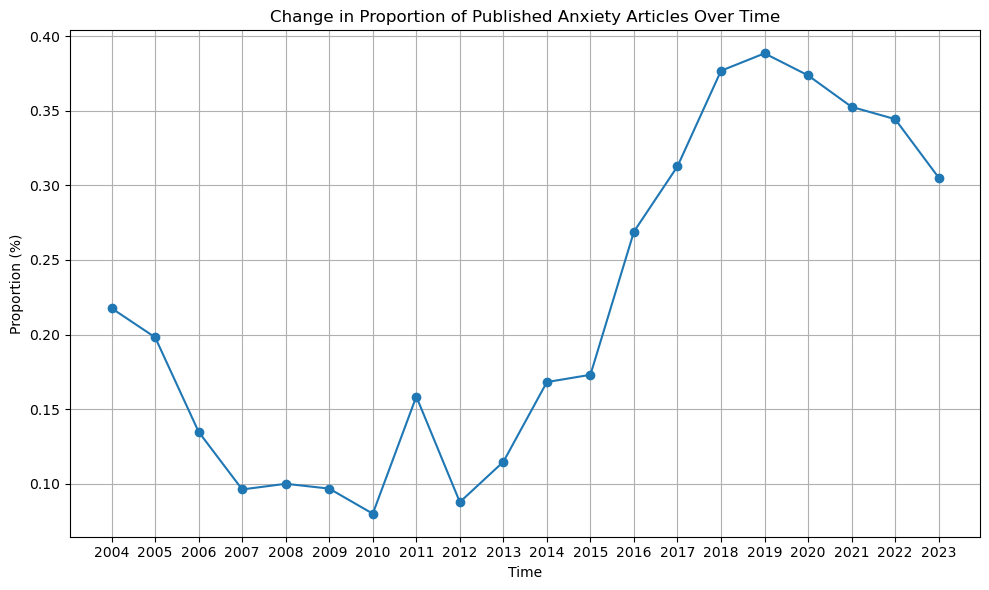

In [50]:
df_probability_anxiety = pd.read_csv('probability_anxiety.csv')
df_probability_anxiety = df_probability_anxiety[df_probability_anxiety['Year'] != 2024]


percentages = df_probability_anxiety['Probability'] * 100

years = df_probability_anxiety['Year'].astype(str)
months = np.linspace(0, len(years)-1, len(years)) 


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, percentages, marker='o', linestyle='-')
plt.title('Change in Proportion of Published Anxiety Articles Over Time')
plt.xlabel('Time')
plt.ylabel('Proportion (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

#### hooray! We can actually see an significant increase, reached a peak during 2020, when  the pandemic hits the hardest

#### `also notice that 2024, only 2 months passed, so we get rid of it`

## For Depression

In [51]:
# Load the combined articles dataset
df = pd.read_csv('combined_articles_guardian.csv')

# Initialize a dictionary to store the number of depression articles by year
depression_articles_by_year = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    year = str(row['Year'])  
    body_text = row['Body Text']
    
    # Check if body_text is a string and contains 'depression'
    if isinstance(body_text, str) and 'depression' in body_text.lower():
        # Increment the count of depression articles for the corresponding year
        if year in depression_articles_by_year:
            depression_articles_by_year[year] += 1
        else:
            depression_articles_by_year[year] = 1

# Print the number of depression articles per year
print("Number of Depression Articles per Year:")
for year, count in depression_articles_by_year.items():
    print(f"Year: {year}, Total Depression Articles: {count}")

# Convert the dictionary to a DataFrame
df_depression_articles = pd.DataFrame(list(depression_articles_by_year.items()), columns=['Year', 'Total Depression Articles'])

# Save the DataFrame to a CSV file
df_depression_articles.to_csv('depression_articles_by_year.csv', index=False)

Number of Depression Articles per Year:
Year: 2024, Total Depression Articles: 21
Year: 2023, Total Depression Articles: 216
Year: 2022, Total Depression Articles: 211
Year: 2021, Total Depression Articles: 202
Year: 2020, Total Depression Articles: 216
Year: 2019, Total Depression Articles: 284
Year: 2018, Total Depression Articles: 282
Year: 2017, Total Depression Articles: 244
Year: 2016, Total Depression Articles: 265
Year: 2015, Total Depression Articles: 228
Year: 2014, Total Depression Articles: 241
Year: 2013, Total Depression Articles: 162
Year: 2012, Total Depression Articles: 150
Year: 2011, Total Depression Articles: 210
Year: 2010, Total Depression Articles: 111
Year: 2009, Total Depression Articles: 160
Year: 2008, Total Depression Articles: 208
Year: 2007, Total Depression Articles: 173
Year: 2006, Total Depression Articles: 194
Year: 2005, Total Depression Articles: 217
Year: 2004, Total Depression Articles: 280


In [52]:


df_depression = pd.read_csv('depression_articles_by_year.csv')
df_total = pd.read_csv('total_articles_by_year.csv')

df_dp = pd.merge(df_total, df_depression, on='Year', how='left')
df_dp['Total Depression Articles'] = df_dp['Total Depression Articles'].fillna(0)

# Calculate the probability of publishing depression articles each year
df_dp['Probability'] = df_dp['Total Depression Articles'] / df_dp['Total Articles']

# Save the results to a CSV file
df_dp.to_csv('probability_depression_by_year.csv', index=False)

#### Proportion of depression articles

##### a plot to visualize 

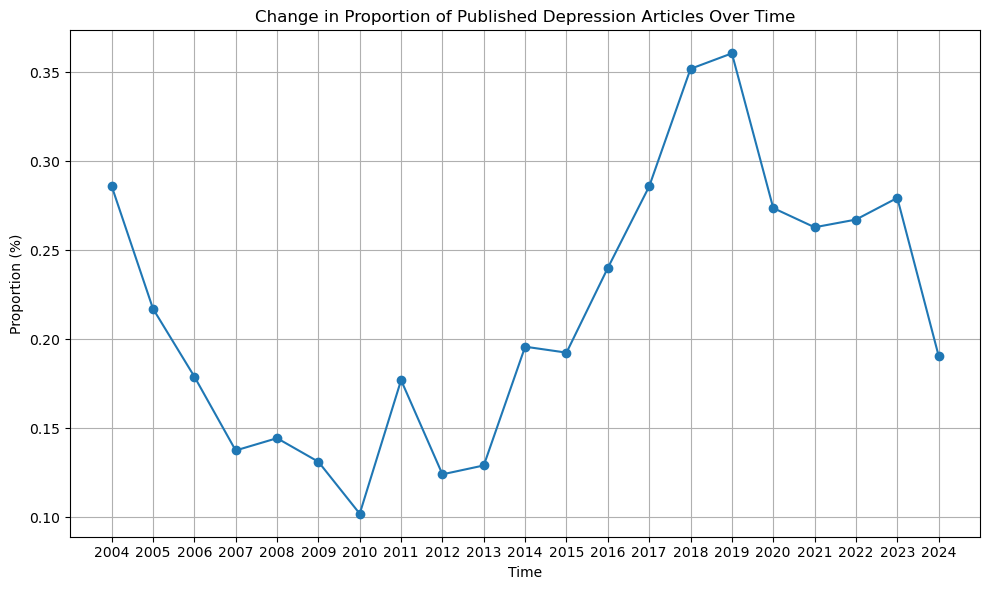

In [53]:
df_probability_anxiety = pd.read_csv('probability_depression_by_year.csv')


percentages = df_dp['Probability'] * 100


years = df_dp['Year'].astype(str)
months = np.linspace(0, len(years)-1, len(years)) 


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(years, percentages, marker='o', linestyle='-')
plt.title('Change in Proportion of Published Depression Articles Over Time')
plt.xlabel('Time')
plt.ylabel('Proportion (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

#### as for depression, it's not that salient, we need to carry out further investiagtion to see if "depression" may also refer to other things...

### Line Show frequency of articles over months (July 1, 2019-January 31, 2024) 

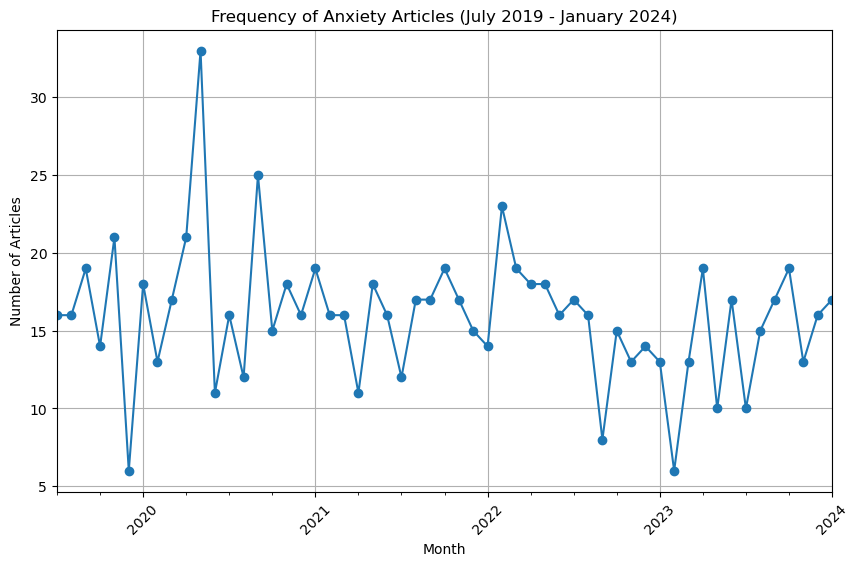

In [54]:
combined_df = pd.read_csv('combined_articles_guardian.csv')
combined_df['Date'] = pd.to_datetime(combined_df['Year'].astype(str) + '-' + combined_df['Month'].astype(str), format='%Y-%m')
filtered_df = combined_df[(combined_df['Date'] >= '2019-07-01') & (combined_df['Date'] <= '2024-01-31')]

# Group by month and count the number of anxiety articles
monthly_counts = filtered_df[filtered_df['Anxiety or Depression'] == 0].groupby('Date').size()

monthly_counts.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Frequency of Anxiety Articles (July 2019 - January 2024)')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Let's check the number of mental illness related articles during the beginning of the pandemic(when regulation was the strictest)

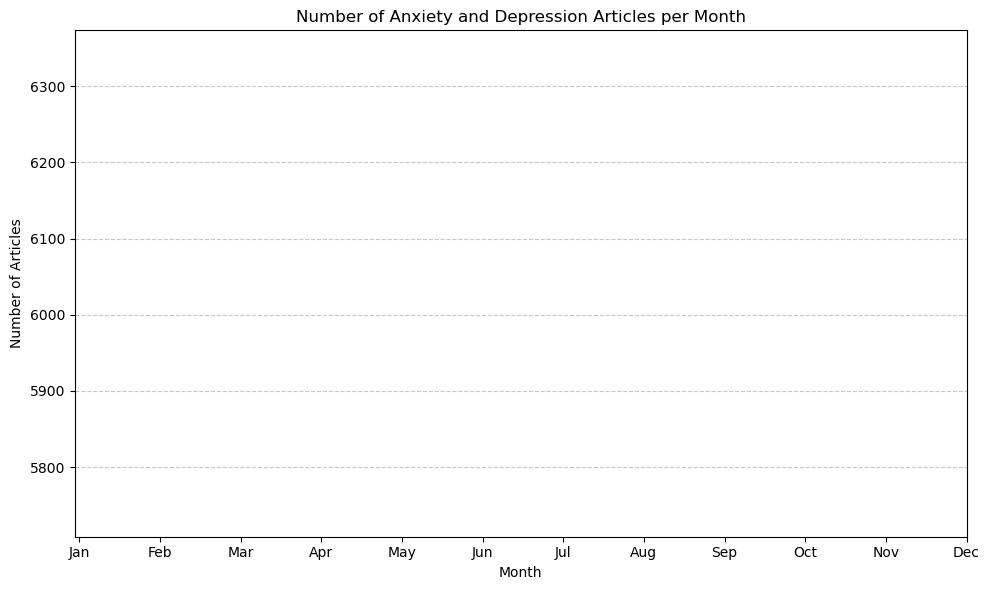

In [55]:
df = pd.read_csv('combined_articles_guardian.csv')

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter the dataframe for articles containing both "anxiety" and "depression"
filtered_df = df[(df['Anxiety or Depression'] == 1) | (df['Anxiety or Depression'] == 0)]  # Selecting both anxiety and depression articles

# Group by month and count the total number of articles
monthly_counts = filtered_df.groupby(filtered_df['Date'].dt.month).size()

# Plotting
plt.figure(figsize=(10, 6))
monthly_counts.plot(kind='line', color='skyblue')
plt.title('Number of Anxiety and Depression Articles per Month')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

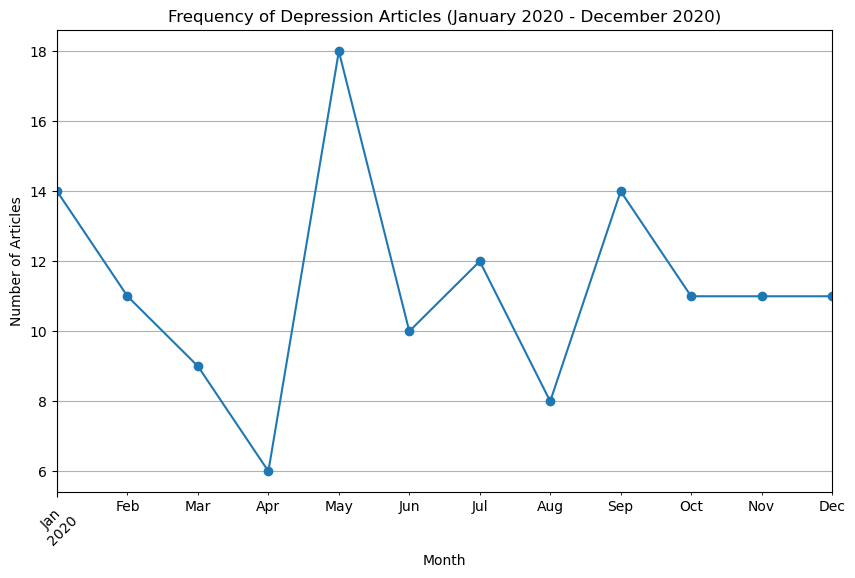

In [56]:
combined_df = pd.read_csv('combined_articles_guardian.csv')

combined_df['Date'] = pd.to_datetime(combined_df['Year'].astype(str) + '-' + combined_df['Month'].astype(str), format='%Y-%m')
filtered_df = combined_df[(combined_df['Date'] >= '2020-01-01') & (combined_df['Date'] <= '2020-12-31')]


monthly_counts = filtered_df[filtered_df['Anxiety or Depression'] == 1].groupby('Date').size()
monthly_counts.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Frequency of Depression Articles (January 2020 - December 2020)')
plt.xlabel('Month')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### we can see a significant increase in APR and May. 
##### according to https://www.cdc.gov/museum/timeline/covid19.html
* April 3, 2020
At a White House press briefing, CDC announces new mask wearing guidelines and recommends that all people wear a mask when outside of the home.